# Final Project: NBA Analysis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import xgboost
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from scipy.stats import randint
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
import pymc3 as pm
import arviz as az
import logging

In [5]:
games = pd.read_csv("games.csv")
games_details = pd.read_csv("games_details.csv")
players = pd.read_csv("players.csv")
ranking = pd.read_csv("ranking.csv")
teams = pd.read_csv("teams.csv")

/var/folders/dv/l2nd8t1935qg0dz8vg__3m980000gn/T/ipykernel_18305/2860099578.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  games_details = pd.read_csv("games_details.csv")


# EDA Section

### 1) [Quantitative] Scatter Plot of Points and Wins
Avg points scored each game vs number of wins for each team per season

Text(0, 0.5, 'Total Wins')

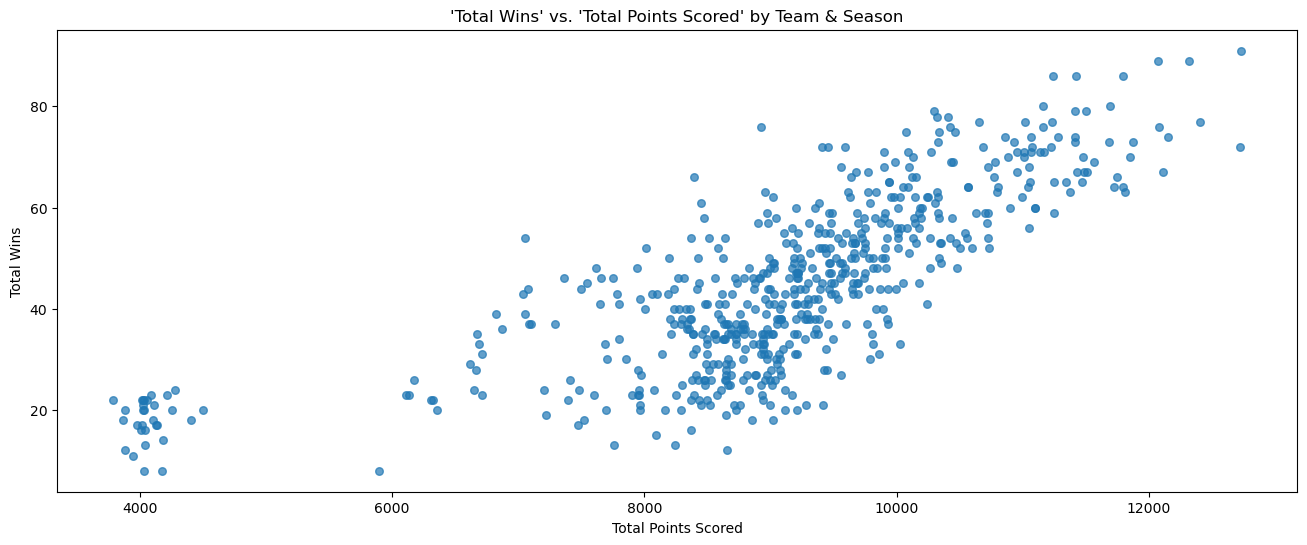

In [6]:
# separate home wins and losses
home_away = games[['TEAM_ID_home', 'TEAM_ID_away', 'HOME_TEAM_WINS', 'SEASON']]
home_wins = home_away[home_away['HOME_TEAM_WINS']==1][['TEAM_ID_home', 'HOME_TEAM_WINS', 'SEASON']]
away_wins = home_away[home_away['HOME_TEAM_WINS']==0][['TEAM_ID_away', 'HOME_TEAM_WINS', 'SEASON']]

# sum up home and away losses to get total number of wins per season
num_home_wins = home_wins.groupby(['TEAM_ID_home', 'SEASON']).sum().reset_index().rename(columns={"TEAM_ID_home": "team_id"})
num_away_wins = away_wins.groupby(['TEAM_ID_away', 'SEASON']).count().reset_index().rename(columns={"TEAM_ID_away": "team_id"})
all_wins = num_home_wins.merge(num_away_wins, how='inner', on=['team_id', 'SEASON'])
all_wins['total_wins'] = all_wins['HOME_TEAM_WINS_x'] + all_wins['HOME_TEAM_WINS_y']
all_wins = all_wins.drop(columns=['HOME_TEAM_WINS_x', 'HOME_TEAM_WINS_y'])

# sum PTS_home and PTS_away by team_id and season
home_points = games[['TEAM_ID_home', 'SEASON', 'PTS_home']].groupby(['TEAM_ID_home', 'SEASON']).sum().reset_index().rename(columns={"TEAM_ID_home": "team_id"})
away_points = games[['TEAM_ID_away', 'SEASON', 'PTS_away']].groupby(['TEAM_ID_away', 'SEASON']).sum().reset_index().rename(columns={"TEAM_ID_away": "team_id"})
all_points = home_points.merge(away_points, how='inner', on=['team_id', 'SEASON'])
all_points['total_points'] = all_points['PTS_home'] + all_points['PTS_away']
all_points = all_points.drop(columns=['PTS_home', 'PTS_away'])

# merge total wins and total points
wins_and_points = all_wins.merge(all_points, how='inner', on=['team_id', 'SEASON'])

# plot total_wins vs. total_points
plt.figure(figsize=(16,6))
plt.scatter(wins_and_points['total_points'], wins_and_points['total_wins'], s=30, alpha= 0.7)
plt.title("'Total Wins' vs. 'Total Points Scored' by Team & Season")
plt.xlabel("Total Points Scored")
plt.ylabel("Total Wins")

### 2) [Quantitative] Histogram of player points scored

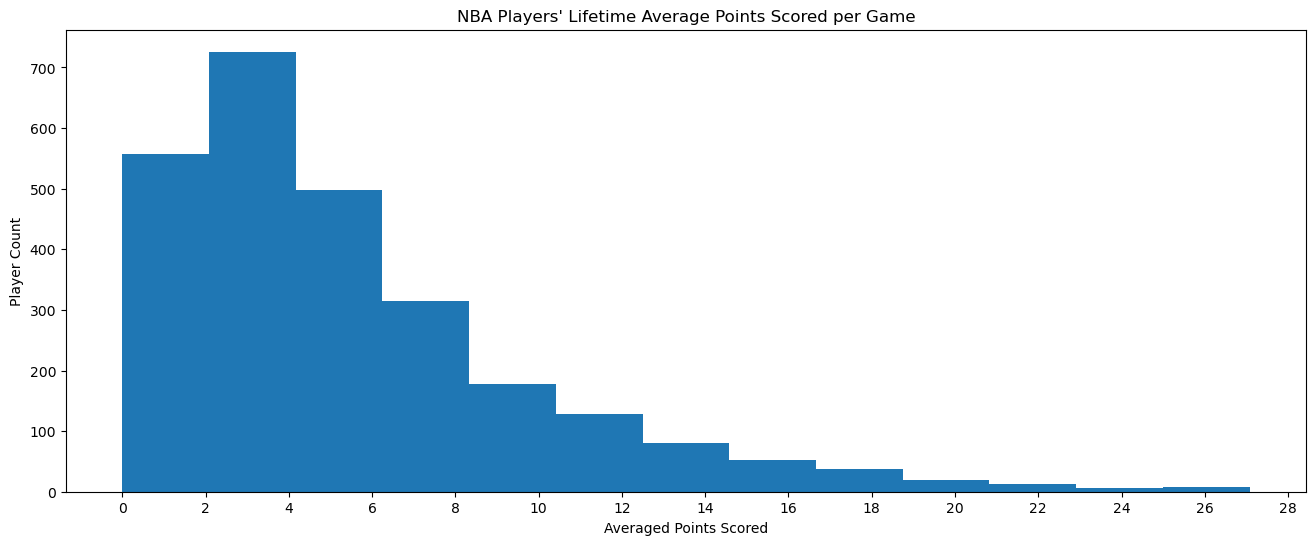

In [7]:
points_id = games_details.groupby(['PLAYER_ID', 'PLAYER_NAME']).apply(lambda x: np.mean(x['PTS']))
points_id_frame=points_id.to_frame().reset_index(level=['PLAYER_ID'], drop=True)
points_id_frame.rename({0:'avg_pts'}, axis=1, inplace=True)
plt.figure(figsize=(16,6))
plt.hist(points_id_frame, bins=13);
plt.xticks(np.arange(0, 30, 2));
plt.xlabel('Averaged Points Scored');
plt.ylabel('Player Count');
plt.title("NBA Players' Lifetime Average Points Scored per Game");

### 3) [Categorical] Stacked Bar Chart of Team Statistics

/var/folders/dv/l2nd8t1935qg0dz8vg__3m980000gn/T/ipykernel_18305/4274519089.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  home_team = eda.groupby("HOME_TEAM_ID").mean()
/var/folders/dv/l2nd8t1935qg0dz8vg__3m980000gn/T/ipykernel_18305/4274519089.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  visitor_team = eda.groupby("VISITOR_TEAM_ID").mean()


<Axes: title={'center': 'Visitor'}, xlabel='ABBREVIATION'>

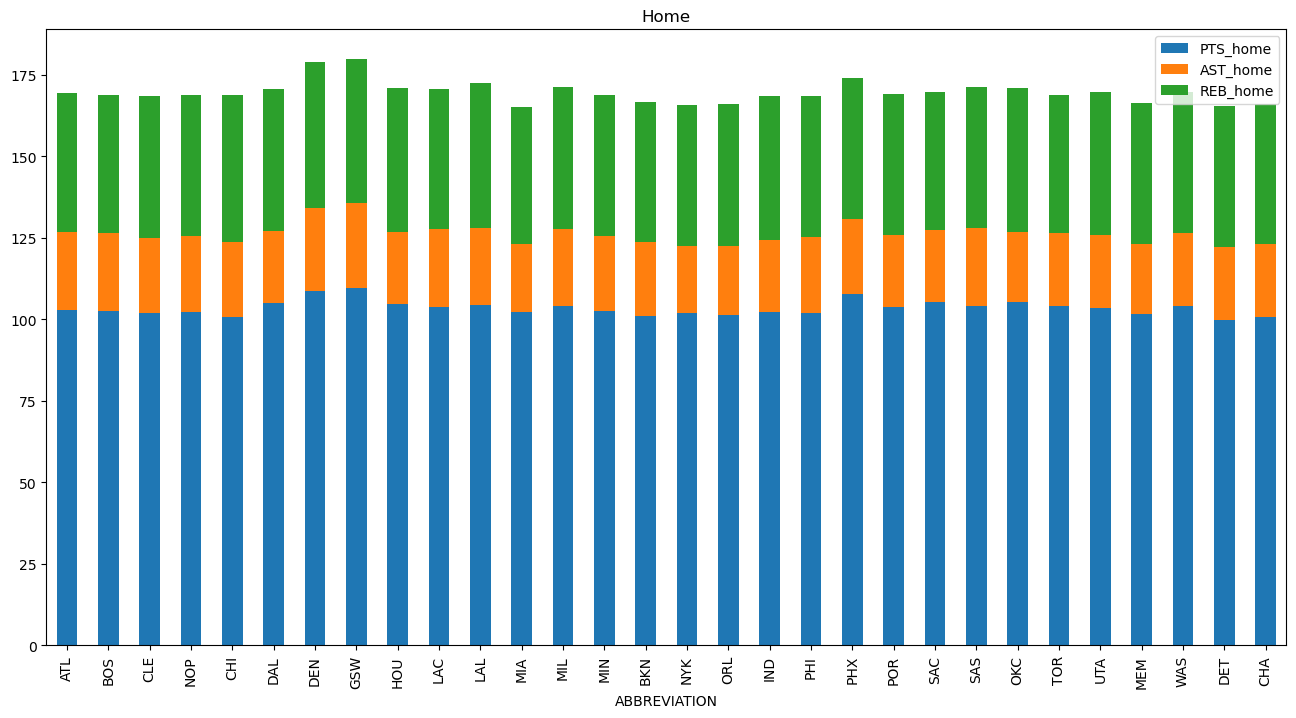

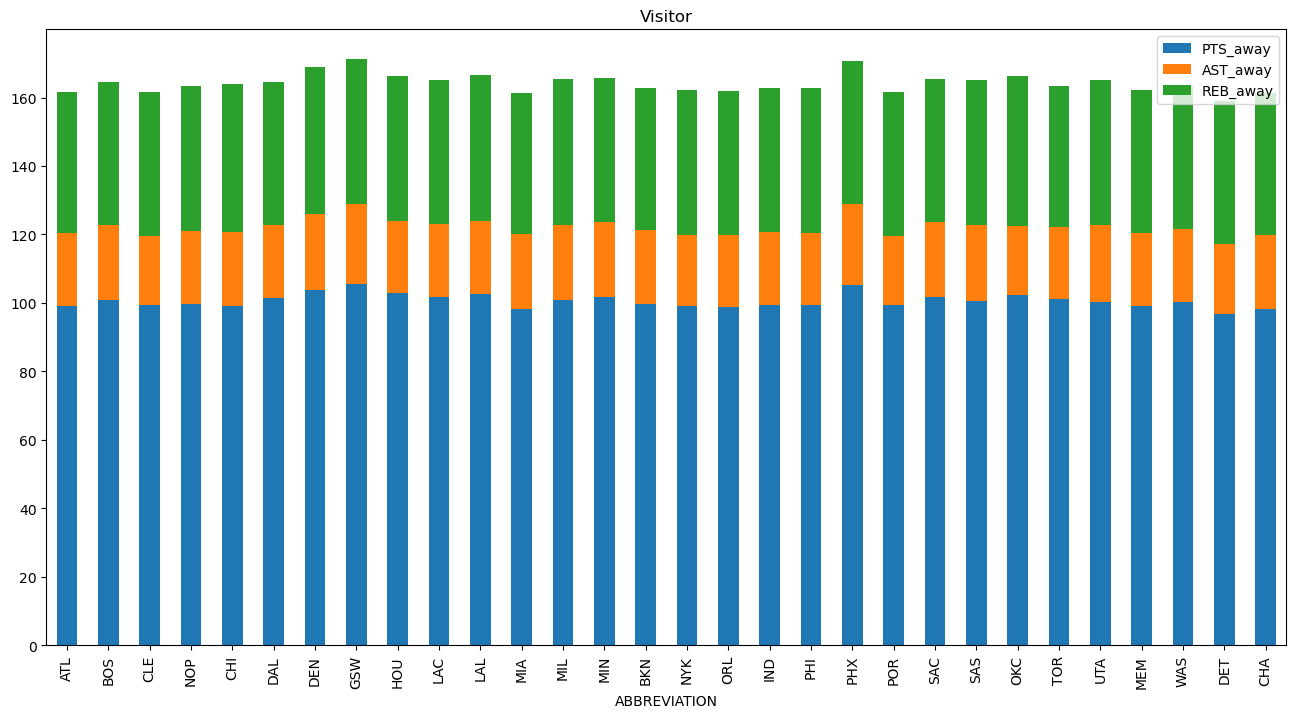

In [8]:
#creating a df that only includes team id and team abbreviation
short_team = teams.drop(columns=["NICKNAME", "YEARFOUNDED","CITY","ARENA","ARENACAPACITY","OWNER","GENERALMANAGER","HEADCOACH","DLEAGUEAFFILIATION","MAX_YEAR","MIN_YEAR","LEAGUE_ID"])
#create a df that merges teams and games and leaves only the necessary columns
eda = games.merge(short_team, left_on ="HOME_TEAM_ID", right_on = "TEAM_ID").rename(columns = {"ABBREVIATION":"HOME_AB"})
eda = games.merge(short_team, left_on ="HOME_TEAM_ID", right_on = "TEAM_ID").rename(columns = {"ABBREVIATION":"HOME_AB"})
eda = eda.merge(short_team, left_on = "VISITOR_TEAM_ID", right_on = "TEAM_ID").rename(columns = {"ABBREVIATION":"VISITOR_AB"})
eda = eda.drop(columns = ["GAME_STATUS_TEXT", "TEAM_ID_home", "FG_PCT_home","FT_PCT_home","TEAM_ID_away","FG3_PCT_home","FG_PCT_away","FT_PCT_away","FG3_PCT_away","HOME_TEAM_WINS","TEAM_ID_x","TEAM_ID_y"])
eda = eda.drop_duplicates(subset = "GAME_ID", keep="first")
#home teams statistics 
home_team = eda.groupby("HOME_TEAM_ID").mean()
home_team = home_team.merge(short_team, left_on = "HOME_TEAM_ID", right_on = "TEAM_ID" ).drop(columns = ["GAME_ID","VISITOR_TEAM_ID","SEASON","PTS_away","AST_away","REB_away"])
home = home_team.set_index("ABBREVIATION").drop(columns="TEAM_ID")
#visitor teams statistics
visitor_team = eda.groupby("VISITOR_TEAM_ID").mean()
visitor_team = visitor_team.merge(short_team, left_on = "VISITOR_TEAM_ID", right_on = "TEAM_ID" ).drop(columns = ["GAME_ID","HOME_TEAM_ID","SEASON","PTS_home","AST_home","REB_home"])
visitor = visitor_team.set_index("ABBREVIATION").drop(columns="TEAM_ID")
#Plot two barcharts (Home and Away)
home.plot(kind='bar', stacked=True, title='Home', figsize=(16,8))
visitor.plot(kind='bar', stacked=True,  title='Visitor', figsize=(16,8))

### 4) [Categorical] Box Plot of Player Statistics

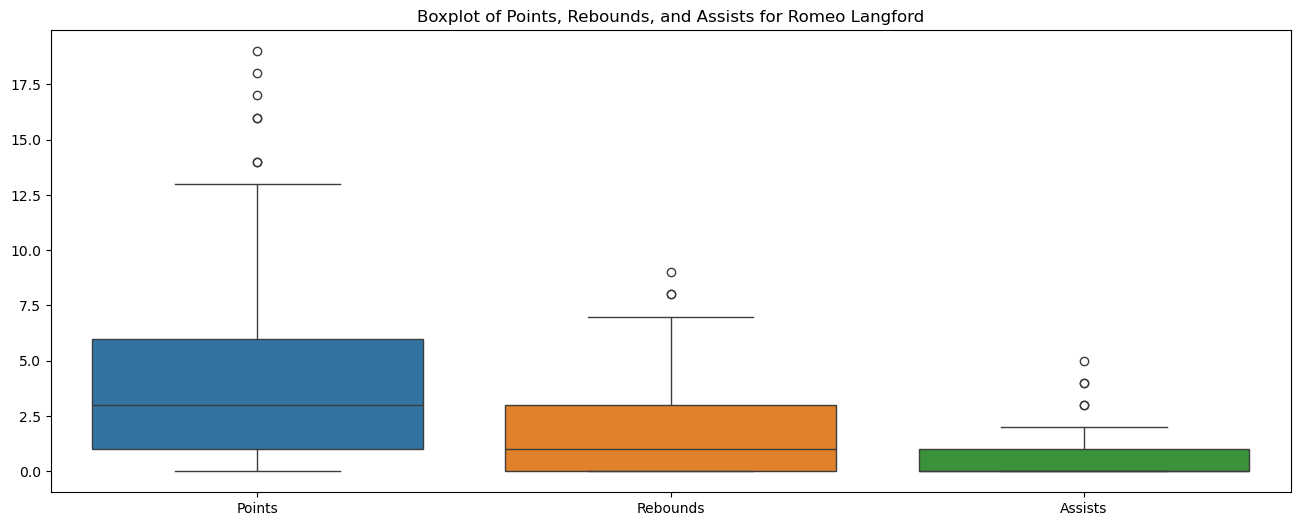

[Text(0.5, 1.0, 'Boxplot of Points, Rebounds, and Assists for Stephen Curry')]

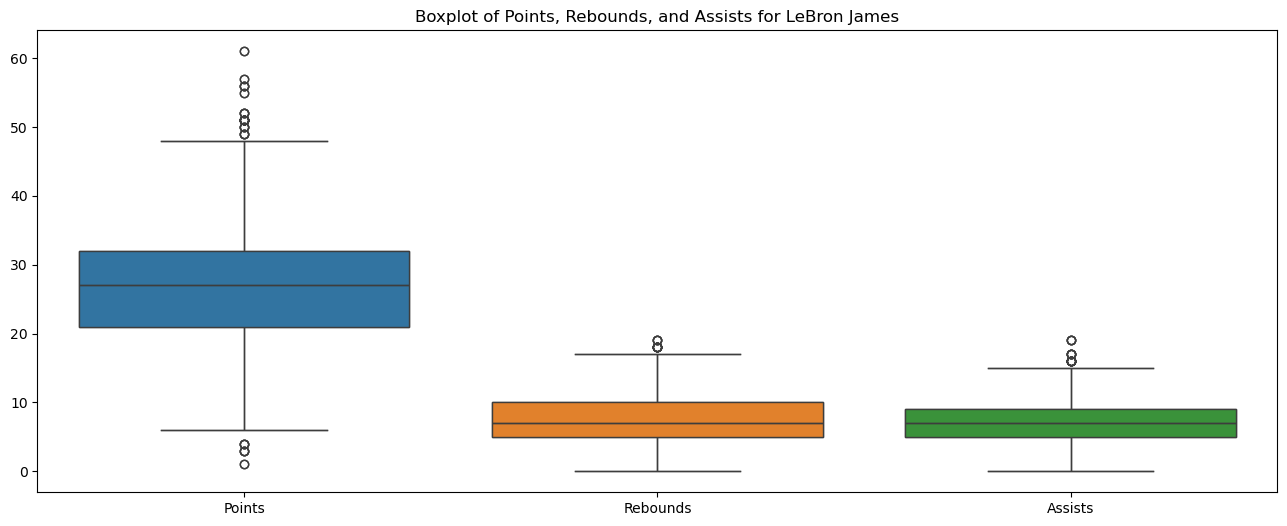

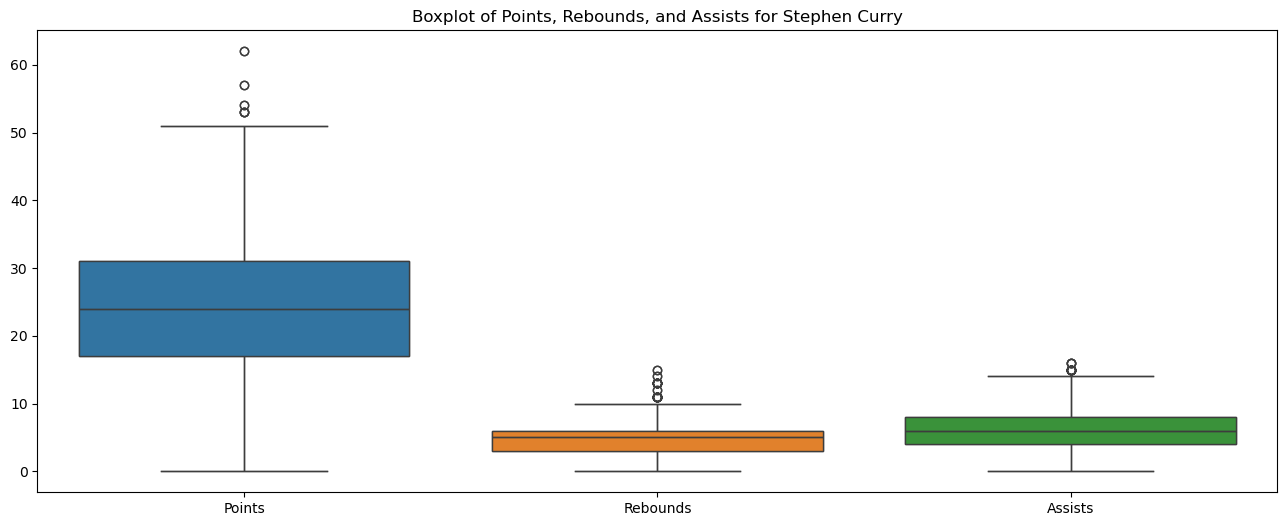

In [9]:
#create a list of names each unique player
name_list = games_details["PLAYER_NAME"].unique().tolist()
def plot_box_player(player, x):
    '''
    Plots the points, rebounds, and assists for a given player.
    '''
    if player in name_list:
        ### Points
        point_array = games_details[games_details["PLAYER_NAME"] == player]["PTS"]
        point_array_clean = point_array[~np.isnan(point_array)]
        
        ### Rebounds
        reb_array = games_details[games_details["PLAYER_NAME"] == player]["REB"]
        reb_array_clean = reb_array[~np.isnan(reb_array)]
        
        ### Assists
        assist_array = games_details[games_details["PLAYER_NAME"] == player]["AST"]
        assist_array_clean = assist_array[~np.isnan(assist_array)]
        
        ### Plotting
        df = pd.DataFrame({'Points': point_array_clean, 'Rebounds': reb_array_clean, 'Assists': assist_array_clean})
        plt.figure(figsize=(16,6))
        sns.boxplot(data=df)
        if x==0:
            plt.title(f'Boxplot of Points, Rebounds, and Assists for {player}')
            plt.show()
        elif x==1:
            return df
    else:
        print("Player not in dataset")
plot_box_player(name_list[0], x=0)
sns.boxplot(data=plot_box_player("LeBron James", x=1)).set(title="Boxplot of Points, Rebounds, and Assists for LeBron James")
sns.boxplot(data=plot_box_player("Stephen Curry", x=1)).set(title="Boxplot of Points, Rebounds, and Assists for Stephen Curry")

### 5) [Quantitative] Heat Maps of Mean and Sum of Team Statistic

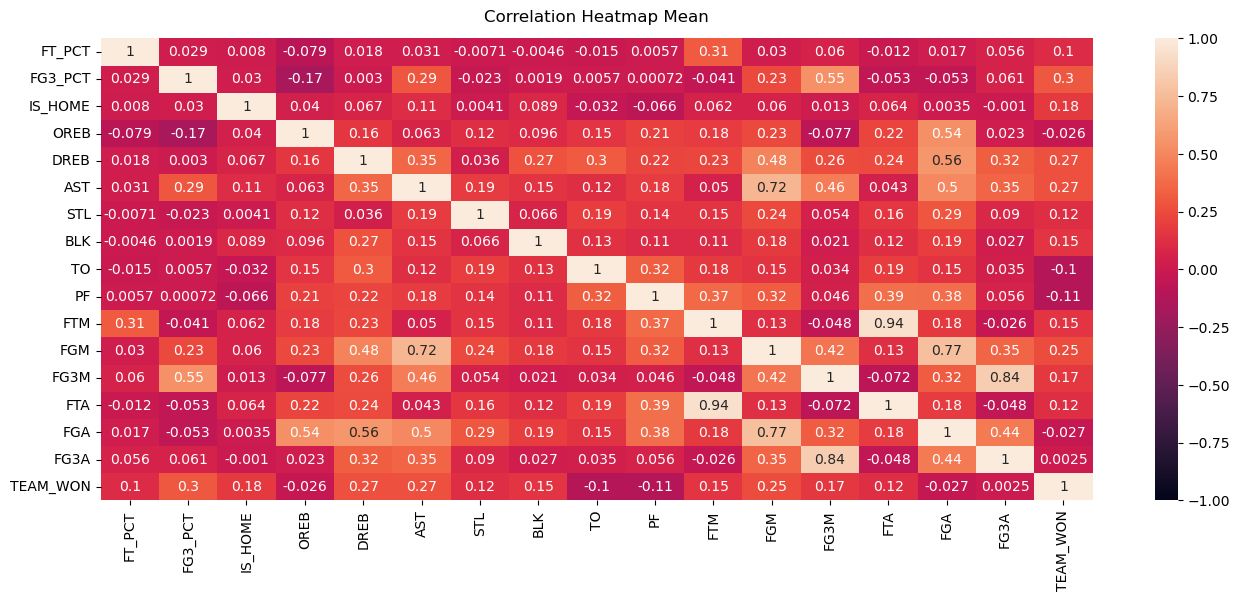

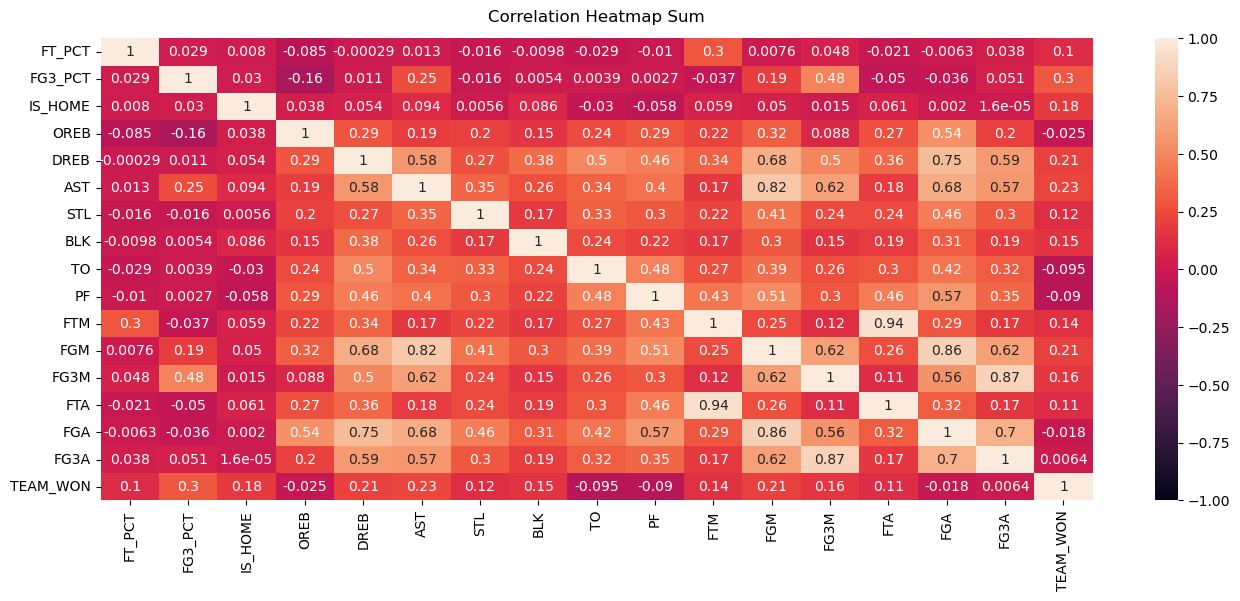

In [10]:
clean_game_stats = pd.read_csv("clean_game_stats.csv")
games_og = pd.read_csv("games.csv")
merged_df = pd.merge(clean_game_stats, games_og, on='GAME_ID')

def did_team_win(row):
    if row['TEAM_ID'] == row['HOME_TEAM_ID']:
        return 1 if row['HOME_TEAM_WINS'] == 1 else 0
    else:
        return 1 if row['HOME_TEAM_WINS'] == 0 else 0

merged_df['TEAM_WON'] = merged_df.apply(did_team_win, axis=1)
dates = clean_game_stats["GAME_DATE_EST"]
merged_df["GAME_DATE_EST"] = dates
column = clean_game_stats.columns.tolist() + ["TEAM_WON"]
main = merged_df[["GAME_ID", "TEAM_ID", "TEAM_WON"]].groupby(["GAME_ID","TEAM_ID"]).mean().reset_index()
merged_mean_df = merged_df.groupby(['GAME_ID', 'TEAM_ID'])[["OREB","DREB","AST","STL","BLK","TO","PF","FTM","FGM","FG3M","FTA","FGA","FG3A"]].mean().reset_index()
merged_sum_df = merged_df.groupby(['GAME_ID', 'TEAM_ID'])[["OREB","DREB","AST","STL","BLK","TO","PF","FTM","FGM","FG3M","FTA","FGA","FG3A"]].sum().reset_index()
df_sum = merged_sum_df.merge(main, on=["GAME_ID","TEAM_ID"])
df_mean = merged_mean_df.merge(main, on=["GAME_ID","TEAM_ID"])
df_mean_prep = df_mean[["GAME_ID","TEAM_ID","OREB","DREB","AST","STL","BLK","TO","PF","FTM","FGM","FGA"]]
df_mix = df_mean_prep.merge(df_sum[["GAME_ID","TEAM_ID","FG3A","TEAM_WON"]])
home_features = games_og[['GAME_ID', 'HOME_TEAM_ID',"FT_PCT_home","FG3_PCT_home"]].rename(columns = {"HOME_TEAM_ID":"TEAM_ID","FT_PCT_home":"FT_PCT","FG3_PCT_home":"FG3_PCT"})
away_features = games_og[['GAME_ID', 'VISITOR_TEAM_ID',"FT_PCT_away","FG3_PCT_away"]].rename(columns = {"VISITOR_TEAM_ID":"TEAM_ID","FT_PCT_away":"FT_PCT","FG3_PCT_away":"FG3_PCT"})
home_features["IS_HOME"] = 1
away_features["IS_HOME"] = 0
team = pd.concat([home_features, away_features])
model_full_sum = team.merge(df_sum, on = ["GAME_ID","TEAM_ID"])
model_full_sum = model_full_sum.drop(columns = ["GAME_ID","TEAM_ID"])

model_full_mean = team.merge(df_mean, on = ["GAME_ID","TEAM_ID"])
model_full_mean = model_full_mean.drop(columns = ["GAME_ID","TEAM_ID"])
model_full_mean
model_full_sum

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(model_full_mean.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Mean', fontdict={'fontsize':12}, pad=12);
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(model_full_sum.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Sum', fontdict={'fontsize':12}, pad=12);

# Bayesian Hierarchical Model

## Data Processing

In [27]:
logger = logging.getLogger("pymc3")
logger.setLevel(logging.ERROR)
games_stats = games_details

In [28]:
games_joined = pd.merge(left=games[['GAME_ID', 'SEASON']], right=games_stats, on='GAME_ID')
desired_season = [2021]
season_games = games_joined[games_joined['SEASON'].isin(desired_season)]
season_games['SEASON'].unique()
eff = season_games[['PLAYER_ID', 'TEAM_ID','PTS', 'REB', 'AST', 'STL', 'BLK', 'TO']]
eff['MissedFG'] = games_stats['FGA'] - games_stats['FGM']
eff['MissedFT'] = games_stats['FTA'] - games_stats['FTM']
eff['GP']=eff.groupby('PLAYER_ID')['PLAYER_ID'].transform('count')

/var/folders/dv/l2nd8t1935qg0dz8vg__3m980000gn/T/ipykernel_18305/500197408.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eff['MissedFG'] = games_stats['FGA'] - games_stats['FGM']
/var/folders/dv/l2nd8t1935qg0dz8vg__3m980000gn/T/ipykernel_18305/500197408.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eff['MissedFT'] = games_stats['FTA'] - games_stats['FTM']
/var/folders/dv/l2nd8t1935qg0dz8vg__3m980000gn/T/ipykernel_18305/500197408.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [29]:
eff_grouped = eff.groupby(by=['TEAM_ID', 'PLAYER_ID']).agg({'PTS':sum, 
                                                            'REB':sum,
                                                            'AST':sum,
                                                            'STL':sum,
                                                            'BLK':sum,
                                                            'TO':sum,
                                                            'MissedFG':sum,
                                                            'MissedFT':sum,
                                                            'GP': [np.mean]
                                                           })
eff_grouped.head()

PTS    REB    AST   STL   BLK    TO MissedFG MissedFT  \
                        sum    sum    sum   sum   sum   sum      sum      sum   
TEAM_ID    PLAYER_ID                                                            
1610612737 101150     375.0   92.0  107.0  30.0   4.0  45.0    201.0     11.0   
           201568     879.0  347.0  110.0  29.0  13.0  48.0    390.0     16.0   
           202362      11.0   15.0   11.0   0.0   0.0   4.0      8.0      1.0   
           203476     183.0  146.0   44.0  15.0  16.0  29.0     71.0      7.0   
           203524      15.0   33.0   19.0   4.0   4.0   2.0     24.0      0.0   

                        GP  
                      mean  
TEAM_ID    PLAYER_ID        
1610612737 101150     68.0  
           201568     78.0  
           202362     51.0  
           203476     86.0  
           203524     28.0

In [30]:
team_roster_dict = {}
calc_player_eff = lambda PTS, REB, AST, STL, BLK, TO, missedFG, missedFT, GP: (PTS + REB + AST + STL + BLK - missedFG - missedFT - TO) / GP

for team_id, _ in eff_grouped.index:
    roster_df = eff_grouped.loc[team_id].reset_index()
    _, PTS, REB, AST, STL, BLK, TO, missedFG, missedFT, GP = roster_df.T.values
    
    eff_score = calc_player_eff(PTS, REB, AST, STL, BLK, TO, missedFG, missedFT, GP)
    roster_df['EFF_SCORE'] = eff_score
    
    team_roster_dict[team_id] = roster_df
    
team_roster_dict[1610612737].head(5)

,PLAYER_ID,PTS,REB,AST,STL,BLK,TO,MissedFG,MissedFT,GP,EFF_SCORE
,,sum,sum,sum,sum,sum,sum,sum,sum,mean,
0,101150,375.0,92.0,107.0,30.0,4.0,45.0,201.0,11.0,68.0,5.161765
1,201568,879.0,347.0,110.0,29.0,13.0,48.0,390.0,16.0,78.0,11.846154
2,202362,11.0,15.0,11.0,0.0,0.0,4.0,8.0,1.0,51.0,0.470588
3,203476,183.0,146.0,44.0,15.0,16.0,29.0,71.0,7.0,86.0,3.453488
4,203524,15.0,33.0,19.0,4.0,4.0,2.0,24.0,0.0,28.0,1.750000


In [31]:
def team_eff_hist(team_id, enclosing_dict=team_roster_dict):
    roster_df = enclosing_dict[team_id]
    plt.hist(roster_df['EFF_SCORE'], density=True)
    plt.xlabel('Player Efficiency Score')
    plt.ylabel('Player Count')

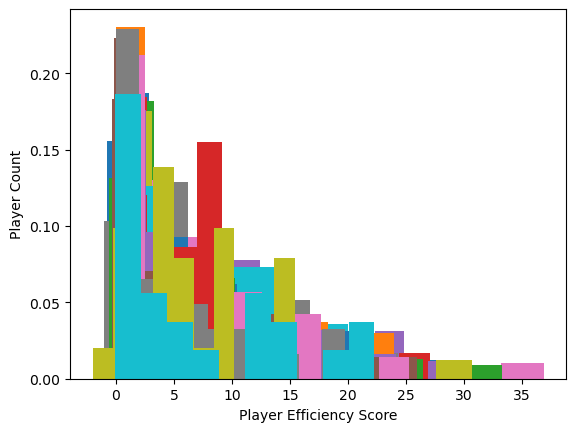

In [32]:
for team_id in team_roster_dict.keys():
    team_eff_hist(team_id)

### Model Definition

In [33]:
alpha_name = 'Jazz'
beta_name = 'Grizzlies'

team_id_alpha = teams[teams['NICKNAME']==alpha_name]['TEAM_ID'].to_numpy()[0]
team_id_beta = teams[teams['NICKNAME']==beta_name]['TEAM_ID'].to_numpy()[0]

roster_alpha = team_roster_dict[team_id_alpha]
roster_beta = team_roster_dict[team_id_beta]

rosterEffAlpha = roster_alpha['EFF_SCORE']
rosterEffBeta = roster_beta['EFF_SCORE']

observed_points_alpha = team_roster_dict[team_id_alpha]['PTS']
observed_points_beta = team_roster_dict[team_id_beta]['PTS']

alpha_name, beta_name

('Jazz', 'Grizzlies')

In [34]:
with pm.Model() as model:
    alpha = pm.Exponential('alpha', lam=2)
    beta = pm.Exponential('beta', lam=2)

    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)

    eff_a = pm.Normal('eff_a', mu=mu_A, sigma=3, observed=rosterEffAlpha)
    eff_b = pm.Normal('eff_b', mu=mu_B, sigma=3, observed=rosterEffBeta)

    trace_exp = pm.sample(500, chains = 4, return_inferencedata = True)
    
trace_exp

There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [35]:
mu_A = trace_exp.posterior['mu_A']
mu_B = trace_exp.posterior['mu_B']
print("The probability that %s is better than %s is %f"%(alpha_name, beta_name, (mu_A > mu_B).mean()))

The probability that Jazz is better than Grizzlies is 0.465000


To find our uncertainty, we will calculate the credibility rating for mu_A and mu_B.

In [78]:
lower_A, upper_A = float(mu_A.quantile(q=.025, dim=['chain', 'draw'])), float(mu_A.quantile(q=.975, dim=['chain', 'draw']))
lower_A, upper_A

(4.771949154644875, 7.004523132436404)

In [79]:
lower_B, upper_B = float(mu_B.quantile(q=.025, dim=['chain', 'draw'])), float(mu_B.quantile(q=.975, dim=['chain', 'draw']))
lower_B, upper_B

(4.867914513777232, 7.038932182211414)

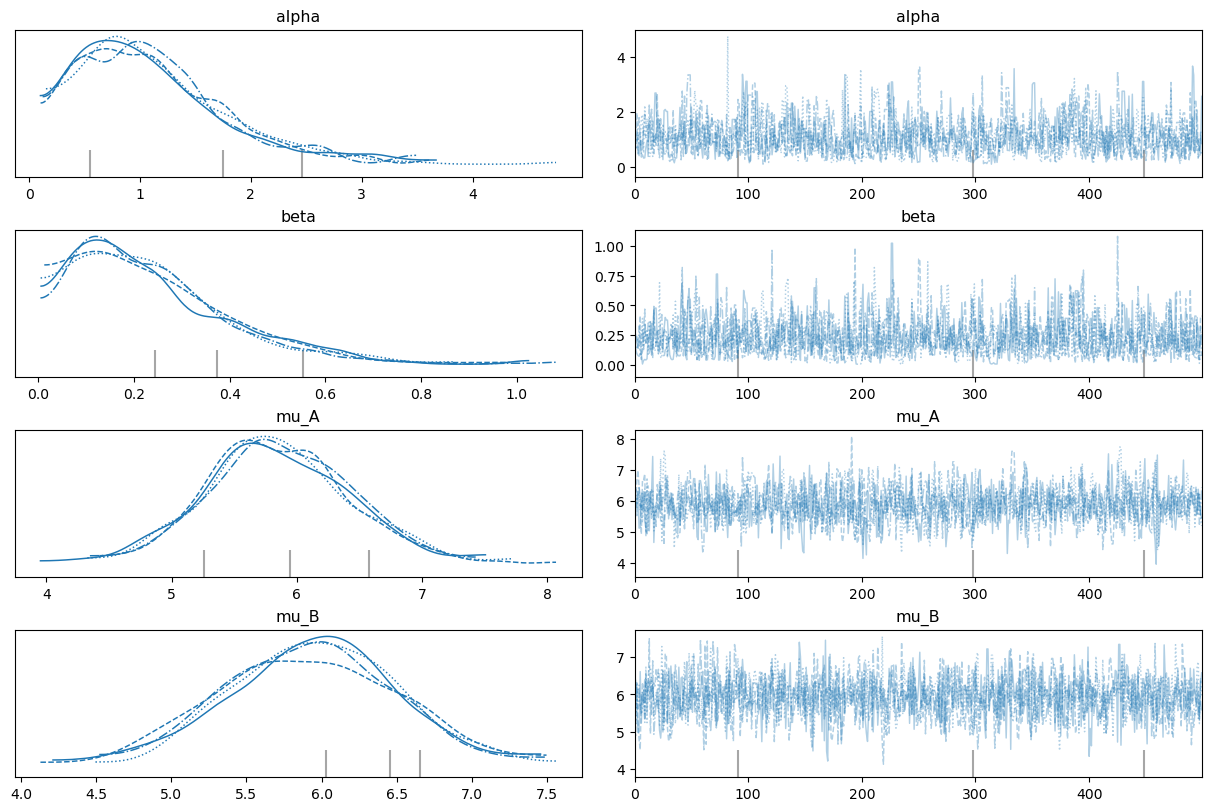

In [36]:
az.plot_trace(trace_exp);

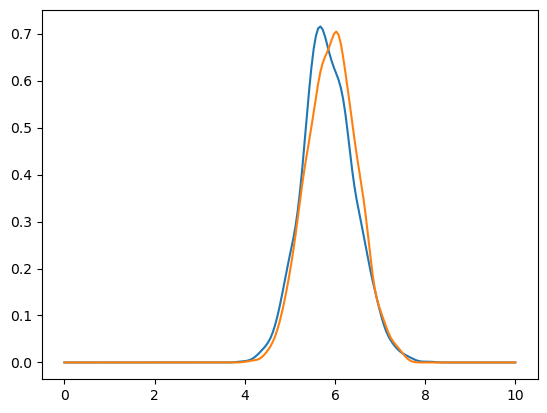

In [37]:
kde_A = stats.gaussian_kde(mu_A.to_numpy().flatten())
kde_B = stats.gaussian_kde(mu_B.to_numpy().flatten())
xs = np.linspace(0, 10, 200)
plt.plot(xs, kde_A(xs));
plt.plot(xs, kde_B(xs));

### Simulating NBA Playoffs

In [38]:
def simulate_matchup(alpha_name, beta_name) -> str:
    team_id_alpha = teams[teams['NICKNAME']==alpha_name]['TEAM_ID'].to_numpy()[0]
    team_id_beta = teams[teams['NICKNAME']==beta_name]['TEAM_ID'].to_numpy()[0]

    roster_alpha = team_roster_dict[team_id_alpha]
    roster_beta = team_roster_dict[team_id_beta]

    rosterEffAlpha = roster_alpha['EFF_SCORE']
    rosterEffBeta = roster_beta['EFF_SCORE']
    
    return run_simulation(alpha_name, beta_name, rosterEffAlpha, rosterEffBeta, observed_points_alpha, observed_points_beta)

def run_simulation(alpha_name, beta_name, rosterEffAlpha, rosterEffBeta, observed_points_alpha, observed_points_beta):
    with pm.Model() as model:
        alpha = pm.Exponential('alpha', lam=2)
        beta = pm.Exponential('beta', lam=2)

        mu_A = pm.Gamma('mu_A', alpha, beta)
        mu_B = pm.Gamma('mu_B', alpha, beta)

        eff_a = pm.Normal('eff_a', mu=mu_A, sigma=3, observed=rosterEffAlpha)
        eff_b = pm.Normal('eff_b', mu=mu_B, sigma=3, observed=rosterEffBeta)
        
        trace = pm.sample(2_000, chains = 4, return_inferencedata = True)
        
    mu_A = trace.posterior['mu_A']
    mu_B = trace.posterior['mu_B']

    return get_match_results(mu_A, mu_B, alpha_name, beta_name)

def get_match_results(mu_A, mu_B, alpha_name, beta_name, thresh=.6):
#     if (mu_A.mean() > mu_B).mean() > thresh:
#         return alpha_name
#     return beta_name
    alpha_mean_greater = (mu_A > mu_B).mean()
    beta_mean_greater = (mu_B > mu_A).mean()
    if alpha_mean_greater > beta_mean_greater:
        return alpha_name
    return beta_name
    

In [39]:
'''
2022 Playoffs
'''
western_conference_matchups_2022 = [
    ['Suns', 'Pelicans'],
    ['Mavericks', 'Jazz'],
    ['Warriors', 'Nuggets'],
    ['Grizzlies', 'Timberwolves']
]

eastern_conference_matchups_2022 = [
    ['Heat', 'Hawks'],
    ['76ers', 'Raptors'],
    ['Bucks', 'Bulls'],
    ['Nets', 'Celtics']
]

observed_2022 = [
    [
        ['Suns', 'Mavericks'],
        ['Warriors', 'Grizzlies']
    ],
    [
        ['Mavericks', 'Warriors']
    ],
    [
        ['Warriors']
    ],
    [
        ['Heat', '76ers'],
        ['Bucks', 'Celtics']
    ],
    [
        ['Heat', 'Celtics']
    ],
    [
        ['Celtics']
    ],
    [
        ['Warriors', 'Celtics']
    ],
    [
        'Warriors'
    ]
]
playoffs_matchups = [western_conference_matchups_2022, eastern_conference_matchups_2022]
observed = observed_2022

In [40]:
'''
2021 Playoffs
'''
western_conference_matchups_2021 = [
    ['Jazz', 'Grizzlies'],
    ['Clippers', 'Mavericks'],
    ['Nuggets', 'Trail Blazers'],
    ['Suns', 'Lakers']
]

eastern_conference_matchups_2021 = [
    ['76ers', 'Wizards'],
    ['Knicks', 'Hawks'],
    ['Bucks', 'Heat'],
    ['Nets', 'Celtics']
]

observed_2021 = [
    [
        ['Jazz', 'Clippers'],
        ['Nuggets', 'Suns']
    ],
    [
        ['Clippers', 'Suns']
    ],
    [
        ['Suns']
    ],
    [
        ['Bucks', 'Heat'],
        ['Celtics', 'Raptors']
    ],
    [
        ['Heat', 'Celtics']
    ],
    [
        ['Heat']
    ],
    [
        ['Lakers', 'Heat']
    ],
    [
        'Lakers'
    ]
]


In [41]:
'''
2020 Playoffs
'''
western_conference_matchups_2020 = [
    ['Lakers', 'Trail Blazers'],
    ['Rockets', 'Thunder'],
    ['Nuggets', 'Jazz'],
    ['Clippers', 'Mavericks']
]

eastern_conference_matchups_2020 = [
    ['Bucks', 'Magic'],
    ['Pacers', 'Heat'],
    ['Celtics', '76ers'],
    ['Raptors', 'Nets']
]

observed_2020 = [
    [
        ['Lakers', 'Rockets'],
        ['Nuggets', 'Clippers']
    ],
    [
        ['Lakers', 'Nuggets']
    ],
    [
        ['Lakers']
    ],
    [
        ['Bucks', 'Heat'],
        ['Celtics', 'Raptors']
    ],
    [
        ['Heat', 'Celtics']
    ],
    [
        ['Heat']
    ],
    [
        ['Lakers', 'Heat']
    ],
    [
        'Lakers'
    ]
]

In [42]:
champion=None
while not champion:
    matchup_cache=[]
    finalists = []
    
    for matchups in playoffs_matchups:
        victors=[]
        while len(matchups[0]) > 1:
            victors=[]
            for matchup in matchups:
                team_a, team_b = matchup
                victor = simulate_matchup(team_a, team_b)
                victors.append(victor)
                print(victors)
            matchups = [victors[i:i+2] for i in range(0, len(victors), 2)]
            matchup_cache.append(matchups)
        finalists.extend(victors)
        
    matchup_cache.append([finalists])
    finalist_a, finalist_b = finalists
    champion = simulate_matchup(finalist_a, finalist_b)
    matchup_cache.append([champion])

There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


['Suns']


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


['Suns', 'Jazz']


There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


['Suns', 'Jazz', 'Warriors']


There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


['Suns', 'Jazz', 'Warriors', 'Timberwolves']


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


['Suns']


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


['Suns', 'Warriors']


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


['Warriors']


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


['Heat']


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


['Heat', 'Raptors']


There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


['Heat', 'Raptors', 'Bulls']


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


['Heat', 'Raptors', 'Bulls', 'Nets']


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


['Heat']


There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


['Heat', 'Bulls']


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


['Bulls']


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


In [43]:
error_count = 0
total = 0
for sublist1, sublist2 in zip(matchup_cache, observed):
    for bracket1, bracket2 in zip(sublist1, sublist2):
        if isinstance(bracket1, list):
            for team in bracket1:
                total += 1
                if team not in bracket2:
                    error_count += 1
        else: 
            if bracket1 != bracket2:
                error_count += 1
                
accuracy = ((total - error_count) / total) * 100
print('Simulation Accuracy: %f ; %s'%(accuracy, str(total - error_count) + '/' + str(total)))

Simulation Accuracy: 43.750000 ; 7/16


# Prediction with GLMs and nonparametric methods

## Data Processing

In [44]:
#clean_game_stats: is a merge of games and game_details and dropping plus-minus, comment, nickname, team city, and start position
clean_game_stats = pd.read_csv("clean_game_stats.csv")
games_og = pd.read_csv("games.csv")

In [45]:
merged_df = pd.merge(clean_game_stats, games_og, on='GAME_ID')

def did_team_win(row):
    if row['TEAM_ID'] == row['HOME_TEAM_ID']:
        return 1 if row['HOME_TEAM_WINS'] == 1 else 0
    else:
        return 1 if row['HOME_TEAM_WINS'] == 0 else 0

merged_df['TEAM_WON'] = merged_df.apply(did_team_win, axis=1)
dates = clean_game_stats["GAME_DATE_EST"]
merged_df["GAME_DATE_EST"] = dates
column = clean_game_stats.columns.tolist() + ["TEAM_WON"]
main = merged_df[["GAME_ID", "TEAM_ID", "TEAM_WON"]].groupby(["GAME_ID","TEAM_ID"]).mean().reset_index()

In [46]:
merged_mean_df = merged_df.groupby(['GAME_ID', 'TEAM_ID'])[["OREB","DREB","AST","STL","BLK","TO","PF","FTM","FGM","FG3M","FTA","FGA","FG3A"]].mean().reset_index()
merged_sum_df = merged_df.groupby(['GAME_ID', 'TEAM_ID'])[["OREB","DREB","AST","STL","BLK","TO","PF","FTM","FGM","FG3M","FTA","FGA","FG3A"]].sum().reset_index()
df_sum = merged_sum_df.merge(main, on=["GAME_ID","TEAM_ID"])
df_mean = merged_mean_df.merge(main, on=["GAME_ID","TEAM_ID"])
df_mean_prep = df_mean[["GAME_ID","TEAM_ID","OREB","DREB","AST","STL","BLK","TO","PF","FTM","FGM","FGA"]]
df_mix = df_mean_prep.merge(df_sum[["GAME_ID","TEAM_ID","FG3A","TEAM_WON"]])

In [47]:
home_features = games_og[['GAME_ID', 'HOME_TEAM_ID',"FT_PCT_home","FG3_PCT_home"]].rename(columns = {"HOME_TEAM_ID":"TEAM_ID","FT_PCT_home":"FT_PCT","FG3_PCT_home":"FG3_PCT"})
away_features = games_og[['GAME_ID', 'VISITOR_TEAM_ID',"FT_PCT_away","FG3_PCT_away"]].rename(columns = {"VISITOR_TEAM_ID":"TEAM_ID","FT_PCT_away":"FT_PCT","FG3_PCT_away":"FG3_PCT"})
home_features["IS_HOME"] = 1
away_features["IS_HOME"] = 0
team = pd.concat([home_features, away_features])

In [48]:
model_full_sum = team.merge(df_sum, on = ["GAME_ID","TEAM_ID"])
model_full_sum = model_full_sum.drop(columns = ["GAME_ID","TEAM_ID"])
model_full_mean = team.merge(df_mean, on = ["GAME_ID","TEAM_ID"])
model_full_mean = model_full_mean.drop(columns = ["GAME_ID","TEAM_ID"])

In [49]:
model_final = model_full_mean.drop(columns=["FT_PCT", "FG3_PCT"])
model_final

,IS_HOME,OREB,DREB,AST,STL,BLK,TO,PF,FTM,FGM,FG3M,FTA,FGA,FG3A,TEAM_WON
0,1,1.454545,2.727273,2.272727,0.909091,0.545455,1.545455,2.181818,2.272727,4.000000,1.181818,2.454545,8.272727,3.090909,1.0
1,1,0.571429,2.285714,1.142857,0.357143,0.214286,0.785714,1.142857,1.428571,3.000000,1.142857,1.500000,6.142857,2.500000,1.0
2,1,1.125000,3.500000,2.750000,1.000000,0.375000,1.250000,2.625000,2.750000,5.125000,1.250000,3.500000,10.625000,4.000000,1.0
3,1,1.083333,3.000000,2.250000,0.666667,0.583333,1.000000,1.916667,1.666667,3.416667,0.916667,1.833333,7.750000,3.083333,1.0
4,1,0.900000,3.800000,2.200000,0.600000,0.700000,1.500000,1.500000,1.600000,3.900000,1.400000,1.600000,9.100000,3.700000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51183,0,0.923077,2.384615,1.307692,1.076923,0.230769,1.153846,2.076923,1.384615,2.307692,0.692308,2.153846,6.307692,1.846154,0.0
51184,0,0.666667,3.250000,1.416667,0.666667,0.250000,1.583333,2.750000,1.750000,2.500000,0.333333,2.750000,6.083333,1.250000,1.0
51185,0,1.000000,2.307692,1.461538,0.538462,0.538462,1.230769,2.076923,2.230769,2.230769,0.615385,3.384615,5.769231,1.230769,0.0
51186,0,1.000000,2.461538,1.384615,0.461538,0.307692,2.076923,2.076923,2.230769,2.307692,0.384615,3.076923,4.923077,1.000000,0.0


## Frequentist GLM (Logistic)

In [52]:
X_GLM_F = model_final.drop(columns=["TEAM_WON"])
X_GLM_F = sm.add_constant(X_GLM_F)
y_GLM_F = model_final["TEAM_WON"]

In [53]:
#Splitting our dataset into 3 categories: Training Set, Validation Set, Test Set
X_GLM_train_val, X_GLM_test, y_GLM_train_val, y_GLM_test = train_test_split(X_GLM_F, y_GLM_F, test_size=0.2, random_state=42)
X_GLM_train, X_GLM_val, y_GLM_train, y_GLM_val = train_test_split(X_GLM_train_val, y_GLM_train_val, test_size=0.2, random_state=42)

In [54]:
#Using the GLM Frequentist model on Training Set and Validation Set
freq_model = sm.GLM(endog = np.array(y_GLM_train), exog = X_GLM_train, 
                  family=sm.families.Binomial())
freq_res = freq_model.fit()
predictions = freq_res.predict(X_GLM_val) >= 0.5
print(freq_res.summary())
accuracy_team_clean = accuracy_score(y_GLM_val, predictions)
print("\nAccuracy Score:", accuracy_score(y_GLM_val, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_GLM_val, predictions))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                32760
Model:                            GLM   Df Residuals:                    32745
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11391.
Date:                Sun, 10 Dec 2023   Deviance:                       22783.
Time:                        16:48:27   Pearson chi2:                 3.28e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4988
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2974      0.125     -2.385      0.0

In [55]:
#Using the GLM Frequentist model on Training Set and Test Set
freq_model = sm.GLM(endog = np.array(y_GLM_train), exog = X_GLM_train, 
                  family=sm.families.Binomial())
freq_res = freq_model.fit()
predictions = freq_res.predict(X_GLM_test) >= 0.5
print(freq_res.summary())
print("\nAccuracy Score:", accuracy_score(y_GLM_test, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_GLM_test, predictions))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                32760
Model:                            GLM   Df Residuals:                    32745
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11391.
Date:                Sun, 10 Dec 2023   Deviance:                       22783.
Time:                        16:48:28   Pearson chi2:                 3.28e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4988
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2974      0.125     -2.385      0.0

## Bayesian GLM (Logistic)

In [56]:
X_GLM_B = model_final.drop(columns=["TEAM_WON"])
X_GLM_B = sm.add_constant(X_GLM_B)
y_GLM_B = model_final["TEAM_WON"]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_GLM_B, y_GLM_B, test_size=0.2, random_state=42)

In [58]:
with pm.Model() as logistic_model:
    # random variables for coefficients with uninformative priors for each parameter
    beta = pm.Normal('beta', mu=0, sigma=2, shape=X_train.shape[1])
    loc = pm.math.dot(X_train, beta)
    
    obs = pm.Bernoulli('obs', p=pm.invlogit(loc), observed=y_train)
    trace = pm.sample(return_inferencedata=True)

In [59]:
# Extract the sampled values for the 'beta' parameter
beta_samples = trace.posterior['beta']

# Calculate the mean (estimate) of the parameters across all samples and chains
mean_beta = np.mean(beta_samples, axis=(0, 1))
std_beta = np.std(beta_samples, axis=(0, 1))

names = ['intercept', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12', 'b13', 'b14']
print("Parameter | Estimate | Std. Dev. | Frequentist | Std. Error")
print("----------|----------|-----------|-----------|-----------|")
for i, (name, arr) in enumerate(zip(names, range(len(names)))):
    print(f"{name:8}| {mean_beta[i]:.6f} | {std_beta[i]:.6f}  | {freq_res.params.values[i]:.6f}  | {freq_res.bse.values[i]:.6f}")

Parameter | Estimate | Std. Dev. | Frequentist | Std. Error
----------|----------|-----------|-----------|-----------|
intercept| -0.291360 | 0.111089  | -0.297450  | 0.124726
b1      | 0.454265 | 0.030475  | 0.419693  | 0.033773
b2      | 3.554053 | 0.058601  | 3.552141  | 0.064962
b3      | 3.551545 | 0.043567  | 3.556967  | 0.048443
b4      | 0.485676 | 0.040864  | 0.515937  | 0.045168
b5      | 3.852957 | 0.065130  | 3.835706  | 0.072163
b6      | 1.119774 | 0.060697  | 1.180186  | 0.069297
b7      | -3.330839 | 0.050088  | -3.357833  | 0.056390
b8      | -0.543124 | 0.036882  | -0.531680  | 0.041643
b9      | 2.045443 | 0.067767  | 1.992112  | 0.074720
b10     | 3.725537 | 0.056471  | 3.697734  | 0.061853
b11     | 2.730601 | 0.079953  | 2.745285  | 0.089860
b12     | -1.250110 | 0.055966  | -1.205346  | 0.061354
b13     | -3.486381 | 0.041418  | -3.481551  | 0.046001
b14     | -0.843072 | 0.035146  | -0.853256  | 0.039217


In [60]:
X_train = sm.add_constant(X_train)
# Calculate the linear combination
linear_combination = np.dot(X_test, mean_beta)
# Apply the sigmoid function
probabilities = 1 / (1 + np.exp(-linear_combination))
# Make predictions (threshold at 0.5)
predictions = (probabilities >= 0.5).astype(int)
# Calculate model accuracy
accuracy_team_clean = accuracy_score(y_test, predictions)
print("\nAccuracy Score:", accuracy_score(y_test, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictions))


Accuracy Score: 0.8423520218792733

Confusion Matrix:
 [[4341  793]
 [ 821 4283]]


# Non-Parametric

## XGBoost Random Forest

In [61]:
#Split our model dataset into training set, validation set, test set
X_xgb=model_full_mean.drop(columns=["TEAM_WON","FT_PCT", "FG3_PCT"])
y_xgb = model_full_mean["TEAM_WON"]
X_xgb_train_vali, X_xgb_test, y_xgb_train_vali, y_xgb_test = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)
X_xgb_train, X_xgb_validation, y_xgb_train, y_xgb_validation = train_test_split(X_xgb_train_vali, y_xgb_train_vali, test_size=0.2, random_state=42)
X_xgb

,IS_HOME,OREB,DREB,AST,STL,BLK,TO,PF,FTM,FGM,FG3M,FTA,FGA,FG3A
0,1,1.454545,2.727273,2.272727,0.909091,0.545455,1.545455,2.181818,2.272727,4.000000,1.181818,2.454545,8.272727,3.090909
1,1,0.571429,2.285714,1.142857,0.357143,0.214286,0.785714,1.142857,1.428571,3.000000,1.142857,1.500000,6.142857,2.500000
2,1,1.125000,3.500000,2.750000,1.000000,0.375000,1.250000,2.625000,2.750000,5.125000,1.250000,3.500000,10.625000,4.000000
3,1,1.083333,3.000000,2.250000,0.666667,0.583333,1.000000,1.916667,1.666667,3.416667,0.916667,1.833333,7.750000,3.083333
4,1,0.900000,3.800000,2.200000,0.600000,0.700000,1.500000,1.500000,1.600000,3.900000,1.400000,1.600000,9.100000,3.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51183,0,0.923077,2.384615,1.307692,1.076923,0.230769,1.153846,2.076923,1.384615,2.307692,0.692308,2.153846,6.307692,1.846154
51184,0,0.666667,3.250000,1.416667,0.666667,0.250000,1.583333,2.750000,1.750000,2.500000,0.333333,2.750000,6.083333,1.250000
51185,0,1.000000,2.307692,1.461538,0.538462,0.538462,1.230769,2.076923,2.230769,2.230769,0.615385,3.384615,5.769231,1.230769
51186,0,1.000000,2.461538,1.384615,0.461538,0.307692,2.076923,2.076923,2.230769,2.307692,0.384615,3.076923,4.923077,1.000000


In [62]:
#First used the model on our train and validation set
xgb = XGBRegressor(max_depth = 6, n_estimators=100)
xgb.fit(X_xgb_train, y_xgb_train)
y_team_pred_clean = xgb.predict(X_xgb_validation)
prediction = y_team_pred_clean>=0.5
accuracy_score(y_xgb_validation, prediction)
classification_random= classification_report(y_xgb_validation, prediction)
print("\nAccuracy Score:",accuracy_score(y_xgb_validation, prediction))
print("\nClassification Report:\n", classification_random)
print("\nConfusion Matrix:\n", confusion_matrix(y_xgb_validation, prediction))


Accuracy Score: 0.8112332112332112

Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.81      0.81      4010
         1.0       0.82      0.81      0.81      4180

    accuracy                           0.81      8190
   macro avg       0.81      0.81      0.81      8190
weighted avg       0.81      0.81      0.81      8190


Confusion Matrix:
 [[3258  752]
 [ 794 3386]]


### Finetuning

#### RandomizeSearchCV

In [63]:
#RandomizeSearch CV Parameter Distribution mainly based on what intuitively works before and samples from the distribution listed to test best result
param_dist = {
    'max_depth': stats.randint(3, 12),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 120)
}

random_search = RandomizedSearchCV(xgb, param_dist,
                     scoring=None, verbose=1)
random_search.fit(X_xgb_train,y_xgb_train)
print(random_search.best_score_)
print(random_search.best_params_)
# After Running the RandomSearchCV these are the results it has output to try
# {'learning_rate': 0.09813524082985725, 'max_depth': 7, 'n_estimators': 112, 'subsample': 0.8608445622986842}
# {'learning_rate': 0.06137116567143513, 'max_depth': 7, 'n_estimators': 106, 'subsample': 0.6734285992131239}

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.4852633632105716
{'learning_rate': 0.10551455094309903, 'max_depth': 8, 'n_estimators': 107, 'subsample': 0.6423225318961328}


In [64]:
#Testing HyperParameters from RandomSearchCV results
xgb = XGBRegressor(max_depth = 7, n_estimators=112,learning_rate= 0.09813524082985725, subsample = 0.8608445622986842)
xgb.fit(X_xgb_train, y_xgb_train)
y_team_pred_clean = xgb.predict(X_xgb_validation)
prediction = y_team_pred_clean>=0.5
accuracy_score(y_xgb_validation, prediction)
classification_random= classification_report(y_xgb_validation, prediction)
print("\nAccuracy Score:",accuracy_score(y_xgb_validation, prediction))


Accuracy Score: 0.8257631257631257


#### GridSearchCV

In [65]:
#Using GridSearchCV which goes through the combinations of parameters to find best result
optimization_dict = {'max_depth': np.arange(2,15),
                     'n_estimators': np.arange(50,120,10)}

grid_search = GridSearchCV(xgb, optimization_dict,
                     scoring= None, verbose=1)

grid_search.fit(X_xgb_train,y_xgb_train)
print(grid_search.best_score_)
print(grid_search.best_params_)
#What GridSearch has previously outputted
#{'max_depth': 3, 'n_estimators': 110}

Fitting 5 folds for each of 91 candidates, totalling 455 fits
0.489535897494574
{'max_depth': 7, 'n_estimators': 110}


In [69]:
#testing the hyperparameters given from gridsearchCV
xgb = XGBRegressor(max_depth = 3, n_estimators=110)
xgb.fit(X_xgb_train, y_xgb_train)
y_team_pred_clean = xgb.predict(X_xgb_validation)
prediction = y_team_pred_clean>=0.5
accuracy_score(y_xgb_validation, prediction)
classification_random= classification_report(y_xgb_validation, prediction)
print("\nAccuracy Score:",accuracy_score(y_xgb_validation, prediction))
print("\nClassification Report:\n", classification_random)


Accuracy Score: 0.8290598290598291

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.83      0.83      4010
         1.0       0.83      0.83      0.83      4180

    accuracy                           0.83      8190
   macro avg       0.83      0.83      0.83      8190
weighted avg       0.83      0.83      0.83      8190



#### Final Test Set

In [70]:
#Using the best hyperparameter received from both randomsearchCV and gridsearchCV we use those parameters on the final test model
xgb = XGBRegressor(max_depth = 7, n_estimators=112,learning_rate= 0.09813524082985725, subsample = 0.8608445622986842)
xgb.fit(X_xgb_train, y_xgb_train)
y_team_pred_clean = xgb.predict(X_xgb_test)
xgb_prediction = y_team_pred_clean>=0.5
accuracy_score(y_xgb_test, xgb_prediction)
classification_random= classification_report(y_xgb_test, xgb_prediction)
print("\nAccuracy Score:",accuracy_score(y_xgb_test, xgb_prediction))
print("\nClassification Report:\n", classification_random)
print("\nConfusion Matrix:\n", confusion_matrix(y_xgb_test, xgb_prediction))


Accuracy Score: 0.819398319984372

Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.83      0.82      5134
         1.0       0.83      0.81      0.82      5104

    accuracy                           0.82     10238
   macro avg       0.82      0.82      0.82     10238
weighted avg       0.82      0.82      0.82     10238


Confusion Matrix:
 [[4265  869]
 [ 980 4124]]


## Neural Network

In [71]:
#Split our model dataset into training set, validation set, test set
X_nn=model_full_mean.drop(columns=["TEAM_WON","FT_PCT", "FG3_PCT"])
y_nn = model_full_mean["TEAM_WON"]
X_nn_train_vali, X_nn_test, y_nn_train_vali, y_nn_test = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)
X_nn_train, X_nn_validation, y_nn_train, y_nn_validation = train_test_split(X_nn_train_vali, y_nn_train_vali, test_size=0.2, random_state=42)

In [72]:
#First used the model on our train and validation set
clf = MLPClassifier(hidden_layer_sizes = 11, max_iter = 90, activation = "logistic", solver = "lbfgs")
clf.fit(X_nn_train, y_nn_train)
prediction_nn = clf.predict(X_nn_validation)>=0.5
accuracy_score(y_nn_validation, prediction_nn)
classification_random= classification_report(y_nn_validation, prediction_nn)
print("\nAccuracy Score:",accuracy_score(y_nn_validation, prediction_nn))
print("\nClassification Report:\n", classification_random)
print("\nConfusion Matrix:\n", confusion_matrix(y_nn_validation, prediction_nn))


Accuracy Score: 0.8499389499389499

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.85      0.85      4010
         1.0       0.86      0.85      0.85      4180

    accuracy                           0.85      8190
   macro avg       0.85      0.85      0.85      8190
weighted avg       0.85      0.85      0.85      8190


Confusion Matrix:
 [[3418  592]
 [ 637 3543]]


/Users/judyhe/opt/anaconda3/envs/data102/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Finetuning

#### RandomizeSearch CV

In [73]:
#RandomizeSearch CV Parameter Distribution mainly based on what intuitively works before and samples from the distribution listed to test best result
param_dist = {
    'hidden_layer_sizes': stats.randint(2, 12),
    'max_iter': stats.randint(50,120),
    'activation': ["identity","logistic","tanh","relu"],
    'solver':["lbfgs","sgd","adam"]
}

random_search = RandomizedSearchCV(clf, param_dist,
                     scoring=None, verbose=1)
random_search.fit(X_nn_train,y_nn_train)
print(random_search.best_score_)
print(random_search.best_params_)
# After Running the RandomSearchCV these are the results it has output to try
#output of randomsearchCVs
#{'activation': 'logistic', 'hidden_layer_sizes': 5, 'max_iter': 85, 'solver': 'lbfgs'}
#accuracy_score =  0.8428857243733082
#{'activation': 'relu', 'hidden_layer_sizes': 10, 'max_iter': 101, 'solver': 'sgd'}
#0.8412380840296575
#{'activation': 'relu', 'hidden_layer_sizes': 9, 'max_iter': 119, 'solver': 'lbfgs'}
#0.8431211015652583

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/judyhe/opt/anaconda3/envs/data102/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (94) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/judyhe/opt/anaconda3/envs/data102/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (94) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/judyhe/opt/anaconda3/envs/data102/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (94) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/judyhe/opt/anaconda3/envs/data102/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (94) reached and the optimization hasn't conv

0.8445970695970695
{'activation': 'tanh', 'hidden_layer_sizes': 6, 'max_iter': 110, 'solver': 'lbfgs'}


/Users/judyhe/opt/anaconda3/envs/data102/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [74]:
#Testing HyperParameters from RandomSearchCV results
clf = MLPClassifier(hidden_layer_sizes = 9, max_iter = 119, activation = "relu", solver = "lbfgs")
clf.fit(X_nn_train, y_nn_train)
prediction_nn = clf.predict(X_nn_validation)>=0.5
accuracy_score(y_nn_validation, prediction_nn)
classification_random= classification_report(y_nn_validation, prediction_nn)
print("\nAccuracy Score:",accuracy_score(y_nn_validation, prediction_nn))
print("\nConfusion Matrix:\n", confusion_matrix(y_nn_validation, prediction_nn))


Accuracy Score: 0.8492063492063492

Confusion Matrix:
 [[3413  597]
 [ 638 3542]]


#### Final Test Set

In [75]:
#Using the best hyperparameter received from both randomsearchCV and gridsearchCV we use those parameters on the final test model
clf = MLPClassifier(hidden_layer_sizes = 5, max_iter = 85, activation = "logistic", solver = "lbfgs")
clf.fit(X_nn_train, y_nn_train)
prediction_nn = clf.predict(X_nn_test)>=0.5
accuracy_score(y_nn_test, prediction_nn)
classification_random= classification_report(y_nn_test, prediction_nn)
print("\nAccuracy Score:",accuracy_score(y_nn_test, prediction_nn))
print("\nClassification Report:\n", classification_random)
print("\nConfusion Matrix:\n", confusion_matrix(y_nn_test, prediction_nn))


Accuracy Score: 0.8420589958976362

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.85      0.84      5134
         1.0       0.85      0.84      0.84      5104

    accuracy                           0.84     10238
   macro avg       0.84      0.84      0.84     10238
weighted avg       0.84      0.84      0.84     10238


Confusion Matrix:
 [[4352  782]
 [ 835 4269]]


/Users/judyhe/opt/anaconda3/envs/data102/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
